In [1]:
import gensim
import numpy as np
import os
import sys

ROOT = os.path.dirname(os.getcwd())
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

sys.path.append('C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\')

In [ ]:
import passatutto_parser as pp
from matchms.importing.load_from_json import as_spectrum


pre_spectrums_query = pp.PassatuttoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()
pre_spectrums_lib = pp.PassatuttoParser('C:\\Users\\Gosia\\Desktop\\Gnps').parse_folder()

# Using MatchMS to create spectra for both
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        

In [ ]:
# Loading the decoy database
pre_spectrums_decoys_cond = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyConditionalPeaks').parse_folder()
pre_spectrums_decoys_rand = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyRandomPeaks').parse_folder()

# Using MatchMS to create decoy spectra
decoys_cond = []
for i, s in enumerate( pre_spectrums_decoys_cond ):
    decoys_cond.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

decoys_rand = []
for i, s in enumerate( pre_spectrums_decoys_rand ):
    decoys_rand.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

In [4]:
from matchms.filtering import normalize_intensities
# Spec2Vec trained model requires normalizing
spectrums_query = [normalize_intensities(s) for s in spectrums_query]
spectrums_lib = [normalize_intensities(s) for s in spectrums_lib]

decoys_cond = [normalize_intensities(s) for s in decoys_cond]
decoys_rand = [normalize_intensities(s) for s in decoys_rand]


Load pretrained spec2vec model

In [5]:
path_models = os.path.join(path_data, "trained_models_1")
model_file = os.path.join(path_models, "spec2vec_size_170.model")

model = gensim.models.Word2Vec.load(model_file)
print(model_file)

C:\Users\Gosia\Desktop\trained_models_1\spec2vec_size_170.model


Create spectrum "documents"

In [6]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]

documents_decoys_cond = [SpectrumDocument(s, n_decimals=2) for s in decoys_cond]
documents_decoys_rand = [SpectrumDocument(s, n_decimals=2) for s in decoys_rand]


Derive embeddings

In [ ]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 70 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_query)):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

In [ ]:


embeddings_spec2vec_decoys_cond = np.zeros((len(documents_decoys_cond), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_decoys_cond)):
    embeddings_spec2vec_decoys_cond[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_decoys_rand = np.zeros((len(documents_decoys_rand), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_decoys_rand)):
    embeddings_spec2vec_decoys_rand[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

In [9]:
import importlib
import cosine_calc
importlib.reload(cosine_calc)

<module 'cosine_calc' from 'C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\cosine_calc.py'>

In [10]:
from cosine_calc import get_spec2vec_hits

hits = get_spec2vec_hits( documents_query, documents_lib, model, precursor_tol=3,
                            intensity_weighting_power=intensity_weighting_power,
                            allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                embeddings_query=embeddings_spec2vec_query, embeddings_library=embeddings_spec2vec_lib)

In [11]:
def add_pmz(specs):
    from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
    from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
    for s in specs:
        s._obj.set('precursor_mz', s._obj.get('parent_mass', 0))
        
add_pmz(documents_query)

In [12]:
import copy
documents_decoys_cond = []
for v,d in zip(embeddings_spec2vec_decoys_cond,documents_lib):
    decoy_doc = copy.deepcopy(d)
    decoy_doc._obj.set('inchi', 'knockoff')
    decoy_doc._obj.set('vector', v)
    documents_decoys_cond.append(decoy_doc)

hits_decoys_cond = get_spec2vec_hits(documents_query, documents_decoys_cond, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                                    embeddings_query=embeddings_spec2vec_query )


documents_decoys_rand = []
for v,d in zip(embeddings_spec2vec_decoys_rand,documents_lib):
    decoy_doc = copy.deepcopy(d)
    decoy_doc._obj.set('inchi', 'knockoff')
    decoy_doc._obj.set('vector', v)
    documents_decoys_rand.append(decoy_doc)

hits_decoys_rand = get_spec2vec_hits(documents_query, documents_decoys_rand, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                                    embeddings_query=embeddings_spec2vec_query )

In [13]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [14]:
# Calculating estimated q-value scores
q_list_decoys = {}
q_list_decoys['spectrum-based method'] = calculate_q_value(hits+hits_decoys_cond,True)
q_list_decoys['naive method'] = calculate_q_value(hits+hits_decoys_rand,True)

In [15]:
from knockoffs import generate_knockoffs

knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=3, diagonal_matrix=110, embeddings=embeddings_spec2vec_lib)
hits_knockoffs = get_spec2vec_hits(documents_query, knockoff_documents, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                   intensity_weighting_power=intensity_weighting_power,
                                   allowed_missing_percentage=allowed_missing_percentage, passatutto=True, embeddings_query=embeddings_spec2vec_query)
q_list_decoys["knockoff method"] = calculate_q_value(hits+hits_knockoffs,True)

Embedding vector size: 170


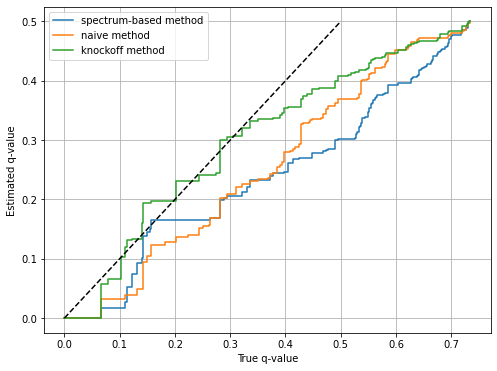

In [16]:
import plot_q_vals
plot_q_vals.plot_q_vals( q_list_true, q_list_decoys )